In [15]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [16]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function.txt', unpack=True, usecols=(0,1,2))

In [17]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [18]:
# uniform prior
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    '''rho_L = pm.Normal("rho_L", mu=error_mean, sigma=np.sqrt(error_var))
    rho_H = pm.Normal("rho_H", mu=error_mean, sigma=np.sqrt(error_var))'''
    rho_L = pm.Uniform("rho_L", lower=0, upper=3)
    rho_H = pm.Uniform("rho_H", lower=0, upper=.5)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)

    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = rho_L * n_LF**(-beta_L) + rho_H * n_HF**(-beta_H)

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=rel_error)

In [19]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho_L, rho_H, beta_L, beta_H, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 146 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [20]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho_L,0.689,0.024,0.644,0.734,0.000,0.000,2709.093,3196.836,1.001
rho_H,0.283,0.123,0.094,0.499,0.003,0.002,2226.379,2072.078,1.005
beta_L,0.629,0.013,0.606,0.654,0.000,0.000,2509.256,2714.903,1.003
beta_H,2.894,0.573,1.721,3.826,0.014,0.010,1708.827,1825.387,1.007
sigma,0.038,0.001,0.037,0.040,0.000,0.000,3176.254,3136.347,1.002


In [21]:
posterior_rho_L = idata["posterior"]["rho_L"]
credible_interval_rho_L = np.percentile(posterior_rho_L, [16, 50, 84])
posterior_rho_H = idata["posterior"]["rho_H"]
credible_interval_rho_H = np.percentile(posterior_rho_H, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_rho_L)
print(credible_interval_rho_H)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[0.66503358 0.68887804 0.71303916]
[0.14340361 0.28084688 0.42858312]
[0.6162995 0.6284727 0.6419917]
[2.31289629 2.92458901 3.40580531]


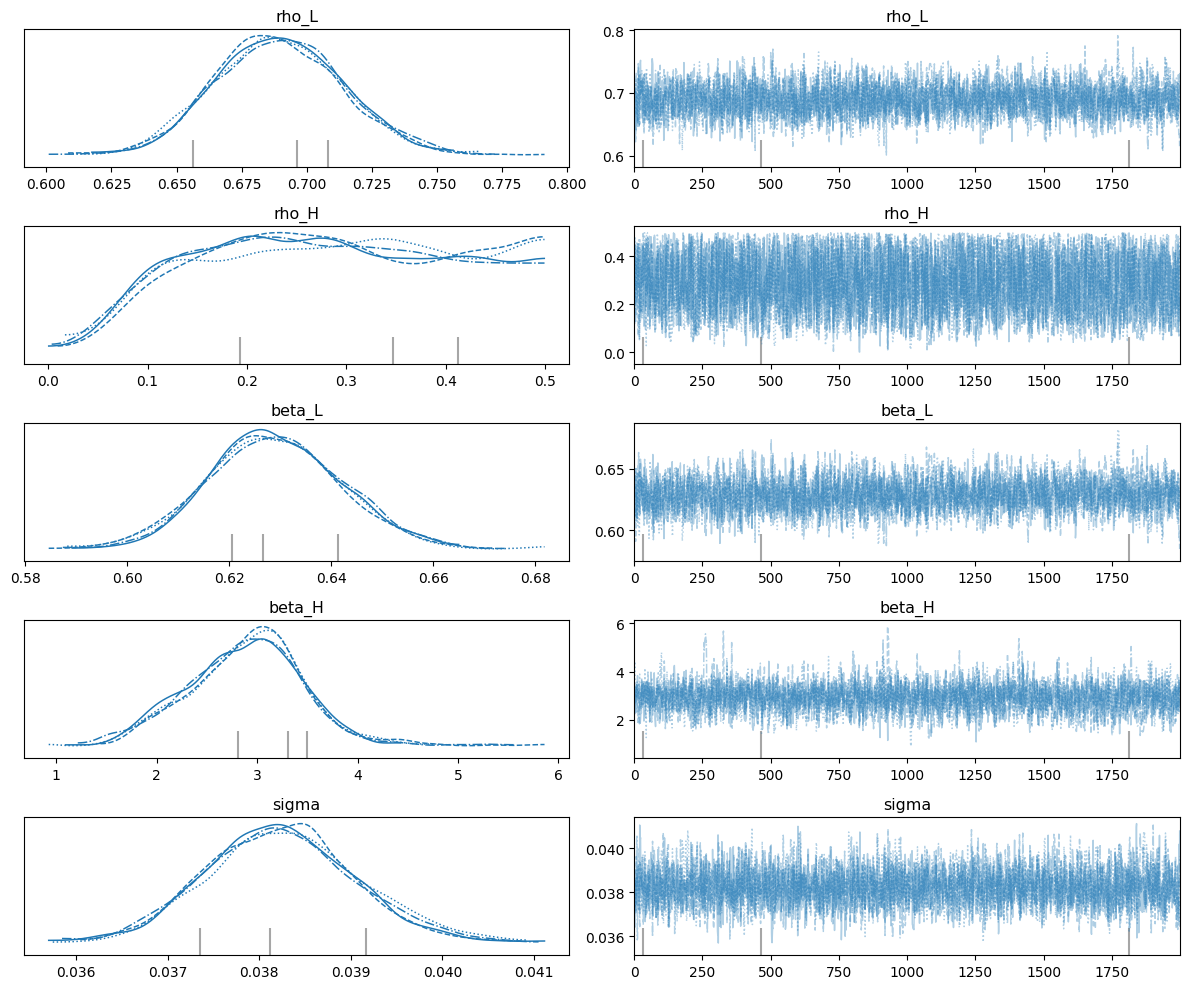

In [22]:
az.plot_trace(idata)
plt.tight_layout()

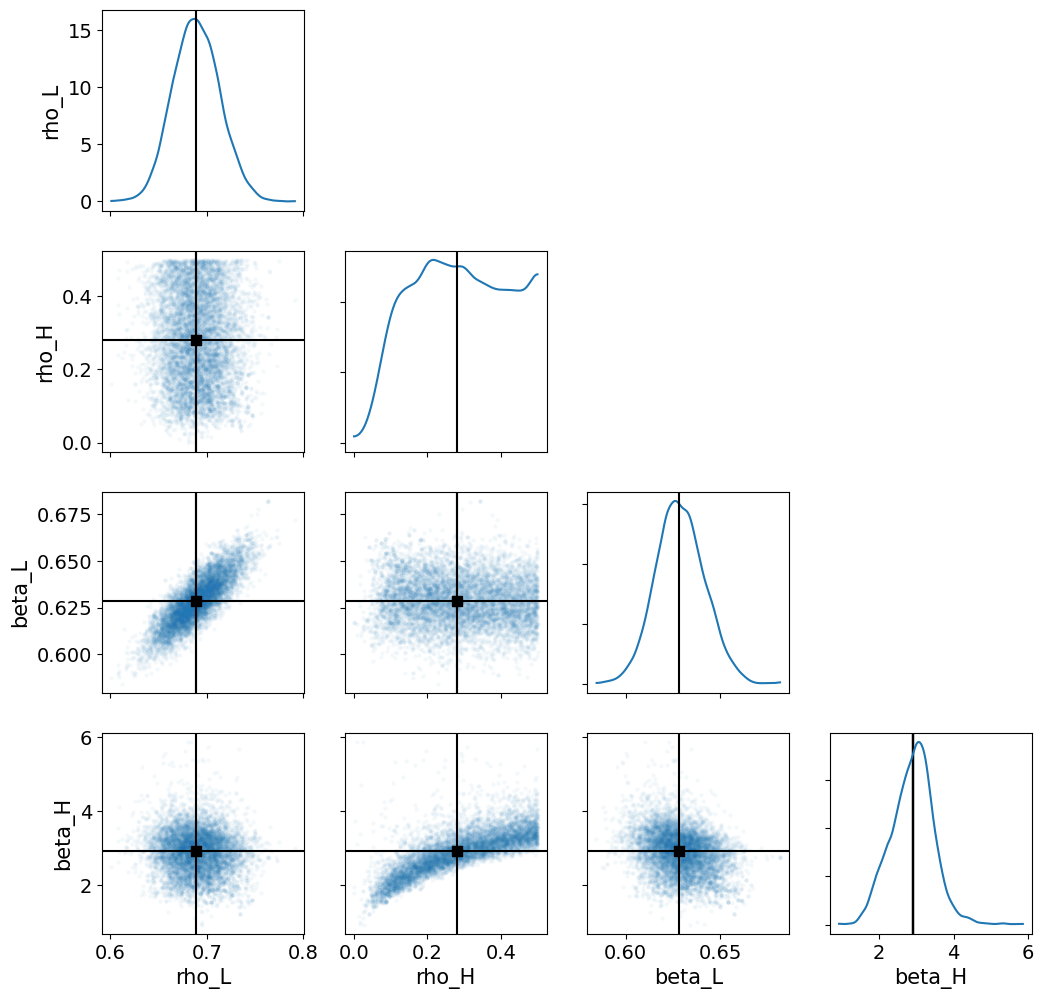

In [23]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="median",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["rho_L", "rho_H", "beta_L", "beta_H"],
);

In [24]:
# loss
phi = rho_L * n_LF**(-beta_L) + rho_H * n_HF**(-beta_H)

In [25]:
rho_L_mean = np.mean(idata["posterior"]["rho_L"].values)
rho_H_mean = np.mean(idata["posterior"]["rho_H"].values)
beta_L_mean = np.mean(idata["posterior"]["beta_L"].values)
beta_H_mean = np.mean(idata["posterior"]["beta_H"].values)

phi = rho_L_mean * n_LF**(-beta_L_mean) + rho_H_mean * n_HF**(-beta_H_mean)
loss = np.mean((phi - rel_error)**2)

In [26]:
loss

0.0014561628334648984